# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje skupa dobijenog automatskom obradom, pre ručne provere i relabeliranja

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('../../data/datasets/action_images_dataset_v1.0')):
    X, y = load_data('../../data/datasets/action_images_dataset_v1.0', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 1895, Forehands count: 2293, Other count: 6142, Serve count: 1587
All strokes count: 11917


In [8]:
## Uncomment and run this cell with the desired num_examples count
## if you'd like to work with less data for testing purposes

# num_examples = 500
# X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=num_examples, stratify=y, random_state=42)
# X = X_sampled
# y = y_sampled

# bh_cnt = sum([1 for l in y if l == 'backhand'])
# fh_cnt = sum([1 for l in y if l == 'forehand'])
# other_cnt = sum([1 for l in y if l == 'other'])
# serve_cnt = sum([1 for l in y if l == 'serve'])
# print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
# print(f'All strokes count: {len(y)}')

## Isprobavanje višeslojnog perceptrona (MLP)

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

In [ ]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = MLPClassifier(
    hidden_layer_sizes=(100, 150, 125, 75, 100),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    random_state=42,
    shuffle=True
)

clf.fit(X_train, y_train)

MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(100, 150, 125, 75, 100),
              learning_rate='adaptive', max_iter=1000, random_state=42)

In [ ]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [ ]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.981002331002331
Precision: 0.9758167006810758
Recall: 0.977950576852654
F1 Score: 0.9767514529326389

Validation set scores:
Accuracy: 0.9296037296037296
Precision: 0.9131120736159737
Recall: 0.9182060132643866
F1 Score: 0.9154015046426367


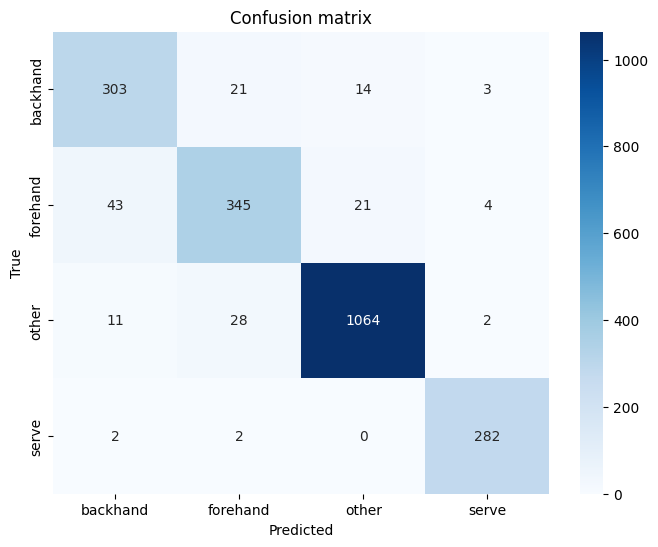

In [ ]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.94      0.98      0.96      1364
    forehand       0.98      0.95      0.96      1651
       other       0.99      0.99      0.99      4423
       serve       0.99      1.00      1.00      1142

    accuracy                           0.98      8580
   macro avg       0.98      0.98      0.98      8580
weighted avg       0.98      0.98      0.98      8580



In [ ]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.84      0.89      0.87       341
    forehand       0.87      0.84      0.85       413
       other       0.97      0.96      0.97      1105
       serve       0.97      0.99      0.98       286

    accuracy                           0.93      2145
   macro avg       0.91      0.92      0.92      2145
weighted avg       0.93      0.93      0.93      2145



Ovako razvijen model s manje više nasumičnim hiperparametrima se prilično muči sa generalizacijom, odnosno vidimo da se model prilično preprilagodio. Nastavljamo dalje.

## Pronalaženje najboljih hiperparametara

In [ ]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [ ]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 150, 100), (75, 100, 200, 150, 100, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__learning_rate': ['adaptive']
}

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('mlp', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42, shuffle=True))])

In [18]:
start = time.time()

grid_search = GridSearchCV(grid_model, param_grid=params, scoring='f1_macro', verbose=True, 
                           cv=kf, return_train_score=True)#, n_jobs=50)
grid_search.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Time taken: 00:01:08.22


In [19]:
best_model = grid_search.best_estimator_

print(f"Best score (GridSearchCV): {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.9109175497952089
Best parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.001}

Training set scores:
Accuracy: 0.9613165486493574
Precision: 0.9501926018867162
Recall: 0.9541471605032699
F1 Score: 0.9521275003049932

Validation set scores:
Accuracy: 0.957000524383849
Precision: 0.9468761969310138
Recall: 0.9520797862728443
F1 Score: 0.9491526252011695


U ovom slučaju smo dobili fenomenalne rezultate, te nećemo proširivati pretragu. U sledećem koraku se prelazi na specijalizovane mreže za slike - CNN-ove, tako da gore navedene rezultate proglasiti za konačne za ovaj model. Ugnježdenom unakrsnom validacijom je pronađen model, koji je mnogo bolji od inicijalnog, jer je umnogome smanjen overfit faktor, odnosno rezultati na trening i validacionom skupu su dosta slični. Videćemo kako će se ponašati na kraju na test skupu i da li ćemo biti u stanju da nadmašimo ovaj rezultat.

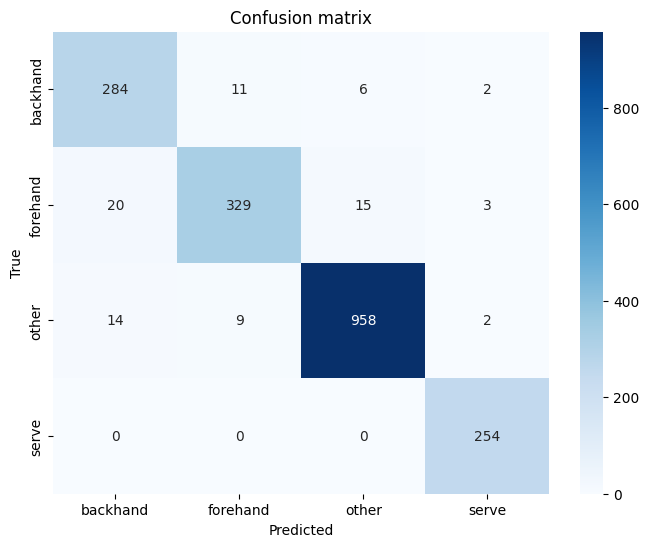

In [20]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.90      0.92      0.91      1213
    forehand       0.93      0.92      0.92      1467
       other       0.99      0.98      0.98      3930
       serve       0.98      1.00      0.99      1016

    accuracy                           0.96      7626
   macro avg       0.95      0.95      0.95      7626
weighted avg       0.96      0.96      0.96      7626



In [22]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.89      0.94      0.91       303
    forehand       0.94      0.90      0.92       367
       other       0.98      0.97      0.98       983
       serve       0.97      1.00      0.99       254

    accuracy                           0.96      1907
   macro avg       0.95      0.95      0.95      1907
weighted avg       0.96      0.96      0.96      1907



Primetimo da je generalizacija modela dobra. Ipak, vidimo da je model prilično dobro naučio da prepozna klase `other` i `serve`, a da se muči s klasama `forehand` i `backhand`, što se donekle može i očekivati, ako se posmatra relativna sličnost ovih udaraca.

## Procena modela na test skupu

In [23]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.9203020134228188
Precision: 0.9012771281047303
Recall: 0.899941709875367
F1 Score: 0.9005397389722665


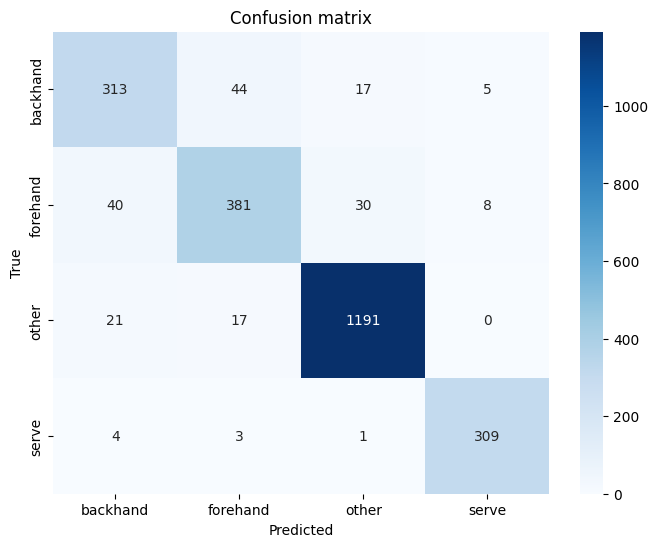

In [24]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.83      0.83      0.83       379
    forehand       0.86      0.83      0.84       459
       other       0.96      0.97      0.97      1229
       serve       0.96      0.97      0.97       317

    accuracy                           0.92      2384
   macro avg       0.90      0.90      0.90      2384
weighted avg       0.92      0.92      0.92      2384



Model daje nešto slabije rezultate na test skupu, ali su rezultati generalno odlični.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [26]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/07_mlp_relabeled_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)